In [59]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/churn-modeling-dataset/Churn_Modelling.csv


In [60]:
df = pd.read_csv('/kaggle/input/churn-modeling-dataset/Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


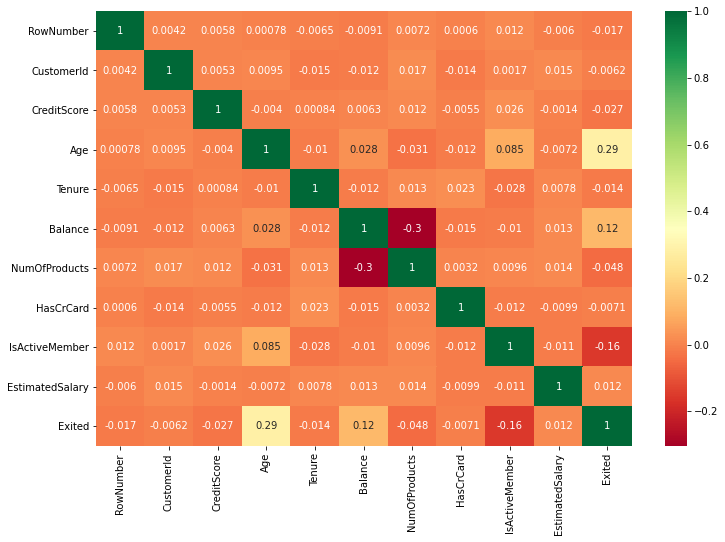

In [61]:
#check the correlation and no. of numerical features in the dataset
import matplotlib.pyplot as plt
import seaborn as sns
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(12,8))
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [62]:
#splitting predictor and target variables
X = df.iloc[:,3:13]
y = df.iloc[:,13]

In [63]:
#changing the categorical feature to numerical by encoding
geography = pd.get_dummies(X['Geography'],drop_first=True)
gender = pd.get_dummies(X['Gender'],drop_first=True)
X.drop(['Geography','Gender'],axis=1,inplace=True)

In [64]:
X = pd.concat([X,geography,gender],axis=1)

In [65]:
X.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Germany,Spain,Male
0,619,42,2,0.00,1,1,1,101348.88,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,1,0


In [66]:
#Hyperparameter optimization
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
}

In [67]:
#using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
import xgboost
classifier=xgboost.XGBClassifier()
random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)

In [68]:
from datetime import datetime

In [69]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [70]:
start_time = timer(None)
random_search.fit(X,y)
timer(start_time)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    4.9s finished



 Time taken: 0 hours 0 minutes and 5.23 seconds.


In [71]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [72]:
random_search.best_params_

{'min_child_weight': 3,
 'max_depth': 6,
 'learning_rate': 0.1,
 'gamma': 0.1,
 'colsample_bytree': 0.5}

In [74]:
classifier = xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=3, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [76]:
from sklearn.model_selection import cross_val_score
score=cross_val_score(classifier,X,y,cv=10)

In [77]:
score

array([0.879, 0.866, 0.874, 0.868, 0.864, 0.856, 0.867, 0.881, 0.86 ,
       0.855])

In [78]:
score.mean()

0.867